In [1]:
import os
import numpy as np
import json
import torch
import torchvision
import numpy as np
import cv2
import random
import detectron2
import itertools
import matplotlib.pyplot as plt
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode

In [3]:
def get_dataset_dicts(img_dir, json_file):
    json_file = os.path.join(img_dir, json_file)
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns['images']):
        record = {}
        filename = os.path.join(img_dir, v["file_name"])
        
        record["file_name"] = filename
        record["id"] = v["id"]
        record["height"] = v["height"]
        record["width"] = v["width"]
        
        annos = imgs_anns["annotations"]
        objs = []
        for anno in annos:
            if anno['image_id'] == v["id"]:
                # BY pass field
                if anno['category_id'] != 1:
                    cat = 0
                    if anno['category_id'] != 0:
                        cat = anno['category_id'] - 1
                    else:
                        cat = 0
                    # buat polygon
                    xywh = anno['bbox']
                    px = [xywh[0], xywh[0]+xywh[2], xywh[0]+xywh[2], xywh[0]]
                    py = [xywh[1], xywh[1], xywh[1]+xywh[3], xywh[1]+xywh[3]]
                    poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
                    poly = list(itertools.chain.from_iterable(poly))
                    obj = {
                        "bbox": anno['bbox'],
                        "bbox_mode": BoxMode.XYWH_ABS,
                        "segmentation": [poly],
                        "category_id": cat,
                        "iscrowd": 0
                    }
                objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [4]:
DATASET_PATH = "../RoboCup-Dataset/"
for d in ["train","valid"]:
    DatasetCatalog.register("robocup_" + d, lambda d=d: get_dataset_dicts(DATASET_PATH + d, d+".json"))
    MetadataCatalog.get("robocup_" + d).set(thing_classes=["ball", "left_goal", "right_goal"])
robocup_metadata = MetadataCatalog.get("robocup_train")

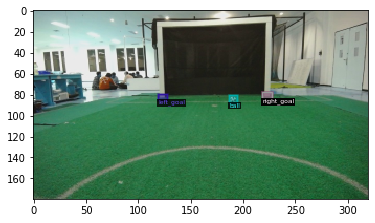

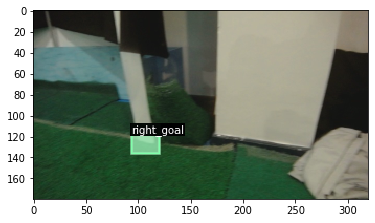

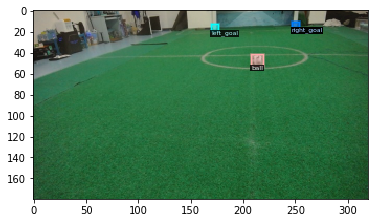

In [5]:
dataset_dicts = get_dataset_dicts(DATASET_PATH+"train", "train.json")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=robocup_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

In [10]:
cfg = get_cfg()
cfg.OUTPUT_DIR = "../weights/retinanet_50/"
cfg.merge_from_file("../../detectron2/configs/COCO-Detection/retinanet_R_50_FPN_1x.yaml")
cfg.DATASETS.TRAIN = ("robocup_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 0
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0001
cfg.SOLVER.MAX_ITER = 10000    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.RETINANET.NUM_CLASSES = 3

# Cek apakah wights sudah ada
weights_filename = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
if os.path.exists(weights_filename):
    print("Load old weights")
    cfg.MODEL.WEIGHTS = weights_filename
else:
    print("Download pretrained weights")
    cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/retinanet_R_50_FPN_1x/137593951/model_final_b796dc.pkl"  # initialize from model zoo

trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

Loading config ../../detectron2/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


WARNING [12/20 11:46:08 d2.config.compat]: Config '../../detectron2/configs/COCO-Detection/retinanet_R_50_FPN_1x.yaml' has no VERSION. Assuming it to be compatible with latest v2.
Load old weights
[12/20 11:46:09 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
 

[12/20 11:46:09 d2.data.build]: Removed 0 images with no usable annotations. 516 images left.
[12/20 11:46:09 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[12/20 11:46:09 d2.data.build]: Using training sampler TrainingSampler
[12/20 11:46:09 d2.engine.train_loop]: Starting training from iteration 5000
[12/20 11:46:18 d2.utils.events]: eta: 0:38:59  iter: 5019  total_loss: 0.787  loss_cls: 0.669  loss_box_reg: 0.138  time: 0.4651  data_time: 0.0497  lr: 0.000250  max_mem: 2716M
[12/20 11:46:28 d2.utils.events]: eta: 0:38:55  iter: 5039  total_loss: 0.907  loss_cls: 0.713  loss_box_reg: 0.176  time: 0.4696  data_time: 0.0553  lr: 0.000250  max_mem: 2716M
[12/20 11:46:37 d2.utils.events]: eta: 0:38:42  iter: 5059  total_loss: 0.823  loss_cls: 0.635  loss_box_reg: 0.178  time: 0.4676  data_time: 0.0549  lr: 0.000250  max_mem: 2716M
[12/20 11:46:46 d2.utils

[12/20 11:52:45 d2.utils.events]: eta: 0:32:08  iter: 5859  total_loss: 0.638  loss_cls: 0.460  loss_box_reg: 0.167  time: 0.4605  data_time: 0.0550  lr: 0.000250  max_mem: 2716M
[12/20 11:52:55 d2.utils.events]: eta: 0:31:59  iter: 5879  total_loss: 0.279  loss_cls: 0.212  loss_box_reg: 0.073  time: 0.4609  data_time: 0.0474  lr: 0.000250  max_mem: 2716M
[12/20 11:53:04 d2.utils.events]: eta: 0:31:50  iter: 5899  total_loss: 0.587  loss_cls: 0.435  loss_box_reg: 0.140  time: 0.4605  data_time: 0.0519  lr: 0.000250  max_mem: 2716M
[12/20 11:53:13 d2.utils.events]: eta: 0:31:42  iter: 5919  total_loss: 0.646  loss_cls: 0.522  loss_box_reg: 0.144  time: 0.4609  data_time: 0.0529  lr: 0.000250  max_mem: 2716M
[12/20 11:53:23 d2.utils.events]: eta: 0:31:33  iter: 5939  total_loss: 0.742  loss_cls: 0.565  loss_box_reg: 0.169  time: 0.4609  data_time: 0.0540  lr: 0.000250  max_mem: 2716M
[12/20 11:53:32 d2.utils.events]: eta: 0:31:23  iter: 5959  total_loss: 0.539  loss_cls: 0.436  loss_box_

[12/20 11:59:37 d2.utils.events]: eta: 0:25:34  iter: 6739  total_loss: 0.423  loss_cls: 0.276  loss_box_reg: 0.104  time: 0.4638  data_time: 0.0551  lr: 0.000250  max_mem: 2716M
[12/20 11:59:46 d2.utils.events]: eta: 0:25:26  iter: 6759  total_loss: 0.575  loss_cls: 0.456  loss_box_reg: 0.156  time: 0.4639  data_time: 0.0517  lr: 0.000250  max_mem: 2716M
[12/20 11:59:55 d2.utils.events]: eta: 0:25:15  iter: 6779  total_loss: 0.809  loss_cls: 0.646  loss_box_reg: 0.166  time: 0.4637  data_time: 0.0552  lr: 0.000250  max_mem: 2716M
[12/20 12:00:04 d2.utils.events]: eta: 0:25:06  iter: 6799  total_loss: 0.556  loss_cls: 0.351  loss_box_reg: 0.162  time: 0.4636  data_time: 0.0532  lr: 0.000250  max_mem: 2716M
[12/20 12:00:13 d2.utils.events]: eta: 0:24:57  iter: 6819  total_loss: 0.382  loss_cls: 0.223  loss_box_reg: 0.144  time: 0.4636  data_time: 0.0507  lr: 0.000250  max_mem: 2716M
[12/20 12:00:23 d2.utils.events]: eta: 0:24:48  iter: 6839  total_loss: 0.586  loss_cls: 0.487  loss_box_

[12/20 12:06:27 d2.utils.events]: eta: 0:18:39  iter: 7619  total_loss: 0.618  loss_cls: 0.450  loss_box_reg: 0.159  time: 0.4643  data_time: 0.0605  lr: 0.000250  max_mem: 2716M
[12/20 12:06:36 d2.utils.events]: eta: 0:18:30  iter: 7639  total_loss: 0.422  loss_cls: 0.307  loss_box_reg: 0.135  time: 0.4644  data_time: 0.0525  lr: 0.000250  max_mem: 2716M
[12/20 12:06:46 d2.utils.events]: eta: 0:18:21  iter: 7659  total_loss: 0.313  loss_cls: 0.239  loss_box_reg: 0.088  time: 0.4645  data_time: 0.0532  lr: 0.000250  max_mem: 2716M
[12/20 12:06:55 d2.utils.events]: eta: 0:18:11  iter: 7679  total_loss: 0.672  loss_cls: 0.474  loss_box_reg: 0.165  time: 0.4645  data_time: 0.0478  lr: 0.000250  max_mem: 2716M
[12/20 12:07:04 d2.utils.events]: eta: 0:18:01  iter: 7699  total_loss: 0.503  loss_cls: 0.378  loss_box_reg: 0.161  time: 0.4646  data_time: 0.0524  lr: 0.000250  max_mem: 2716M
[12/20 12:07:14 d2.utils.events]: eta: 0:17:51  iter: 7719  total_loss: 0.644  loss_cls: 0.468  loss_box_

[12/20 12:13:15 d2.utils.events]: eta: 0:11:43  iter: 8499  total_loss: 0.366  loss_cls: 0.300  loss_box_reg: 0.094  time: 0.4643  data_time: 0.0473  lr: 0.000250  max_mem: 2716M
[12/20 12:13:25 d2.utils.events]: eta: 0:11:34  iter: 8519  total_loss: 0.736  loss_cls: 0.481  loss_box_reg: 0.175  time: 0.4643  data_time: 0.0570  lr: 0.000250  max_mem: 2716M
[12/20 12:13:34 d2.utils.events]: eta: 0:11:25  iter: 8539  total_loss: 0.743  loss_cls: 0.581  loss_box_reg: 0.169  time: 0.4644  data_time: 0.0504  lr: 0.000250  max_mem: 2716M
[12/20 12:13:44 d2.utils.events]: eta: 0:11:16  iter: 8559  total_loss: 0.468  loss_cls: 0.407  loss_box_reg: 0.125  time: 0.4645  data_time: 0.0595  lr: 0.000250  max_mem: 2716M
[12/20 12:13:53 d2.utils.events]: eta: 0:11:06  iter: 8579  total_loss: 0.410  loss_cls: 0.294  loss_box_reg: 0.152  time: 0.4644  data_time: 0.0575  lr: 0.000250  max_mem: 2716M
[12/20 12:14:02 d2.utils.events]: eta: 0:10:56  iter: 8599  total_loss: 0.718  loss_cls: 0.529  loss_box_

[12/20 12:20:02 d2.utils.events]: eta: 0:04:50  iter: 9379  total_loss: 0.591  loss_cls: 0.432  loss_box_reg: 0.134  time: 0.4639  data_time: 0.0519  lr: 0.000250  max_mem: 2716M
[12/20 12:20:12 d2.utils.events]: eta: 0:04:40  iter: 9399  total_loss: 0.511  loss_cls: 0.409  loss_box_reg: 0.113  time: 0.4638  data_time: 0.0451  lr: 0.000250  max_mem: 2716M
[12/20 12:20:21 d2.utils.events]: eta: 0:04:31  iter: 9419  total_loss: 0.727  loss_cls: 0.583  loss_box_reg: 0.134  time: 0.4639  data_time: 0.0513  lr: 0.000250  max_mem: 2716M
[12/20 12:20:30 d2.utils.events]: eta: 0:04:22  iter: 9439  total_loss: 0.583  loss_cls: 0.438  loss_box_reg: 0.104  time: 0.4639  data_time: 0.0523  lr: 0.000250  max_mem: 2716M
[12/20 12:20:40 d2.utils.events]: eta: 0:04:12  iter: 9459  total_loss: 0.626  loss_cls: 0.579  loss_box_reg: 0.153  time: 0.4639  data_time: 0.0528  lr: 0.000250  max_mem: 2716M
[12/20 12:20:49 d2.utils.events]: eta: 0:04:03  iter: 9479  total_loss: 0.657  loss_cls: 0.550  loss_box_

OrderedDict()

# Testing the Model

In [17]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("robocup_valid")
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.2
predictor = DefaultPredictor(cfg)

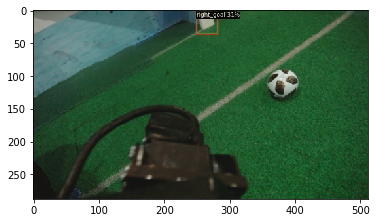

FPS :  3.2022281128226426


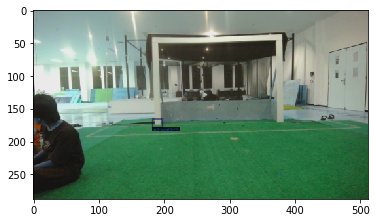

FPS :  3.248120114427144


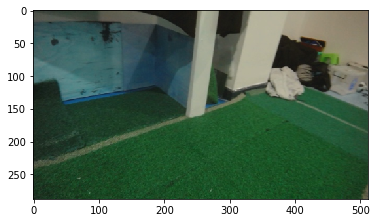

FPS :  2.831016621736366


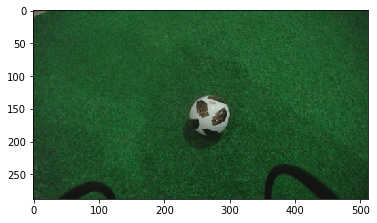

FPS :  3.3260067102119404


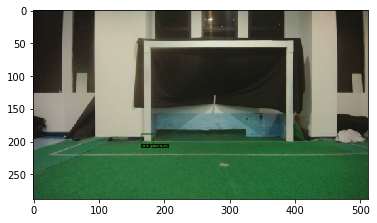

FPS :  3.3162242060495752


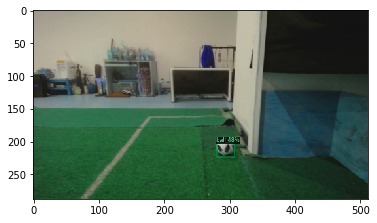

FPS :  3.2212609316403356


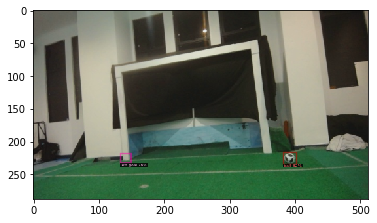

FPS :  3.040580176622141


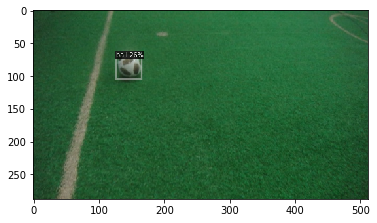

FPS :  3.255812725936172


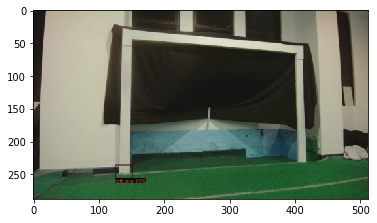

FPS :  3.3204772464044625


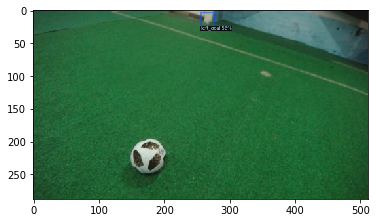

FPS :  3.1037559088446933


In [22]:
import time
dataset_dicts = get_dataset_dicts(DATASET_PATH+"valid", "valid.json")
for d in random.sample(dataset_dicts, 10):  
    start_time = time.time()
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=robocup_metadata, 
                   scale=0.8
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image()[:, :, ::-1])
    plt.show()
    end_time = time.time()
    print("FPS : ", (1/(end_time - start_time)))